In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Cell 2: Data Loading and Initial Trimming
print("Loading datasets...")
logon = pd.read_csv('dataset/logon.csv')
users = pd.read_csv('dataset/users.csv')

print(f"Original logon dataset shape: {logon.shape}")
# Trim logon to 1,500,000 rows for this analysis
logon = logon.head(800000)
print(f"Trimmed logon dataset shape to {len(logon):,} samples.")
print(f"Users dataset shape: {users.shape}")

Loading datasets...
Original logon dataset shape: (198047, 5)
Trimmed logon dataset shape to 198,047 samples.
Users dataset shape: (4000, 4)


In [3]:
# Cell 3 (Revised): Preprocessing and Improved Feature Extraction
print("Starting preprocessing and initial feature extraction...")

# Drop 'id' column
if 'id' in logon.columns:
    logon = logon.drop(columns=['id'])

# Convert 'date' to datetime
logon['date'] = pd.to_datetime(logon['date'])

# Basic time-based features
logon['hour'] = logon['date'].dt.hour
logon['weekday'] = logon['date'].dt.weekday # Monday=0, Sunday=6

# --- Redefined, Stricter Proxy Label for Evaluation ---
# Anomaly is now a much rarer event: logons on weekdays between midnight and 5 AM.
# This is a better proxy for a true anomaly than "outside 9-5".
logon['is_suspicious'] = (
    (logon['hour'] >= 0) & 
    (logon['hour'] <= 5) & 
    (logon['weekday'] < 5)
).astype(int)

print("\n--- Dataset Info with New Proxy Label ---")
print(f"Total records: {len(logon):,}")
print(f"Suspicious activities (proxy): {logon['is_suspicious'].sum():,} ({logon['is_suspicious'].mean()*100:.2f}%)")
print("This is a more realistic anomaly rate for unsupervised learning.")

Starting preprocessing and initial feature extraction...

--- Dataset Info with New Proxy Label ---
Total records: 198,047
Suspicious activities (proxy): 5,035 (2.54%)
This is a more realistic anomaly rate for unsupervised learning.


Generating EDA visualizations...


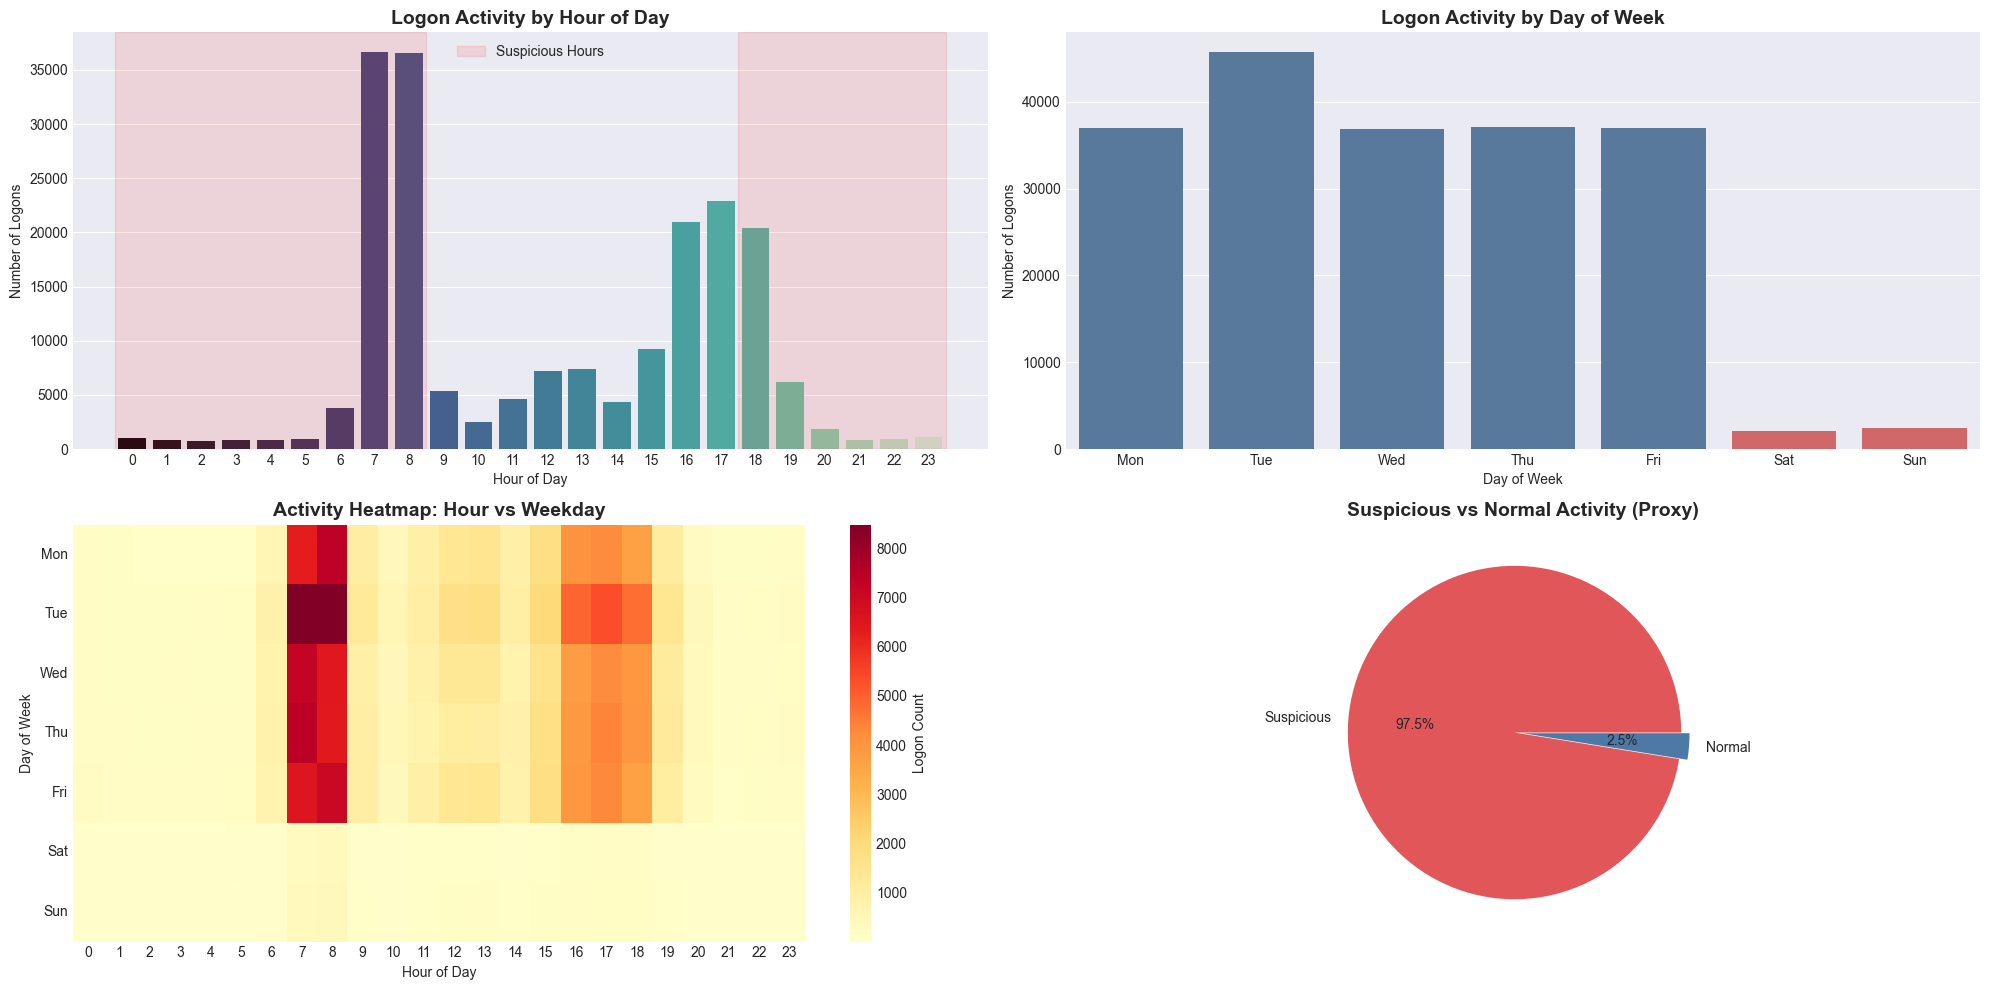

In [4]:
# Cell 4: EDA Visualizations
print("Generating EDA visualizations...")
fig = plt.figure(figsize=(20, 10))

# 1. Logons by hour of day
ax1 = plt.subplot(2, 2, 1)
hourly_counts = logon.groupby('hour').size()
bars = sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=ax1, palette='mako')
ax1.set_title('Logon Activity by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Logons')
ax1.axvspan(-0.5, 8.5, alpha=0.1, color='red', label='Suspicious Hours')
ax1.axvspan(17.5, 23.5, alpha=0.1, color='red')
ax1.legend()

# 2. Logons by day of week
ax2 = plt.subplot(2, 2, 2)
weekday_counts = logon.groupby('weekday').size()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, ax=ax2, palette=['#4e79a7']*5 + ['#e15759']*2)
ax2.set_title('Logon Activity by Day of Week', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Logons')
ax2.set_xticklabels(weekday_labels)

# 3. Heatmap of activity by hour and weekday
ax3 = plt.subplot(2, 2, 3)
pivot_data = logon.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
sns.heatmap(pivot_data, cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Logon Count'})
ax3.set_title('Activity Heatmap: Hour vs Weekday', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Day of Week')
ax3.set_yticklabels(weekday_labels, rotation=0)

# 4. Suspicious vs Normal activity
ax4 = plt.subplot(2, 2, 4)
suspicious_counts = logon['is_suspicious'].value_counts()
ax4.pie(suspicious_counts.values, labels=['Suspicious', 'Normal'], autopct='%1.1f%%', 
        colors=['#e15759', '#4e79a7'], explode=[0.05, 0])
ax4.set_title('Suspicious vs Normal Activity (Proxy)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
# Cell 4 (Corrected): Advanced Feature Engineering
print("Starting advanced feature engineering...")

# 1. User-PC Interaction Frequency
# Anomaly signal: A user logging into a rarely used PC for them.
print("-> Creating 'user_pc_combo_freq' feature.")
user_pc_freq = logon.groupby(['user', 'pc']).size().reset_index(name='user_pc_combo_freq')
# --- FIX: Reassign the merged dataframe back to 'logon' ---
logon = logon.merge(user_pc_freq, on=['user', 'pc'], how='left')


# 2. User-specific Hour and Weekday Frequencies
# Anomaly signal: A user logging in at an unusual hour or day for them.
for feature in ['hour', 'weekday']:
    print(f"-> Creating 'user_{feature}_freq' feature.")
    freq = logon.groupby(['user', feature]).size().reset_index(name=f'user_{feature}_freq')
    # --- FIX: Reassign the merged dataframe back to 'logon' ---
    logon = logon.merge(freq, on=['user', feature], how='left')
    

# 3. Time Since User's Last Logon
# Anomaly signal: Unusually long or short time between logons for a user.
print("-> Creating 'time_since_last_logon' feature.")
logon = logon.sort_values(by=['user', 'date'])
# --- FIX: Directly assign the new column to the dataframe ---
logon['time_since_last_logon'] = logon.groupby('user')['date'].diff().dt.total_seconds().fillna(0)


# Final check for any NaNs introduced by merges/diffs
logon.fillna(0, inplace=True)
print("\nAdvanced feature engineering complete.")
print("Columns in logon dataframe:", logon.columns.tolist())
logon.head()

Starting advanced feature engineering...
-> Creating 'user_pc_combo_freq' feature.
-> Creating 'user_hour_freq' feature.
-> Creating 'user_weekday_freq' feature.
-> Creating 'time_since_last_logon' feature.

Advanced feature engineering complete.
Columns in logon dataframe: ['date', 'user', 'pc', 'activity', 'hour', 'weekday', 'is_suspicious', 'user_pc_combo_freq', 'user_hour_freq', 'user_weekday_freq', 'time_since_last_logon']


,date,user,pc,activity,hour,weekday,is_suspicious,user_pc_combo_freq,user_hour_freq,user_weekday_freq,time_since_last_logon
1562,2011-05-02 07:46:00,AAB0162,PC-6599,Logon,7,0,0,42,21,8,0.0
8926,2011-05-02 18:41:00,AAB0162,PC-6599,Logoff,18,0,0,42,21,8,39300.0
10826,2011-05-03 07:44:00,AAB0162,PC-6599,Logon,7,1,0,42,21,10,46980.0
18002,2011-05-03 18:45:00,AAB0162,PC-6599,Logoff,18,1,0,42,21,10,39660.0
19829,2011-05-04 07:33:00,AAB0162,PC-6599,Logon,7,2,0,42,21,8,46080.0


In [6]:
# Cell 5 (Revised): Train-Test Split with New Features
print("Preparing data for modeling with new features...")
feature_columns = [
    'user', 'pc', 'activity', 'hour', 'weekday',
    'user_pc_combo_freq', 'user_hour_freq', 'user_weekday_freq', 
    'time_since_last_logon'
]
target_column = 'is_suspicious'

X = logon[feature_columns]
y = logon[target_column]

# Split the data into 80% training and 20% testing
# Using 1.2M for train, 300k for test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train):,}")
print(f"Testing set size: {len(X_test):,}")

Preparing data for modeling with new features...
Training set size: 158,437
Testing set size: 39,610


In [7]:
# Cell 6 (Revised): Label Encoding and Scaling
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

print("Encoding categorical variables...")
for col in ['user', 'pc', 'activity']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = X_test[col].map(lambda s: '-1' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '-1')
    X_test_encoded[col] = le.transform(X_test_encoded[col])
    label_encoders[col] = le

print("Scaling features...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Feature preparation complete.")

Encoding categorical variables...
Scaling features...
Feature preparation complete.


In [8]:
# Cell 7 (Improved): Isolation Forest Training & F1-Score Thresholding
print("Training Isolation Forest model...")
iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1, n_estimators=150)
iso_forest.fit(X_train_scaled)

# --- Threshold Optimization using F1-Score on Training Data ---
print("Optimizing anomaly threshold for best F1-Score...")
train_scores_iso = iso_forest.decision_function(X_train_scaled) * -1

# Calculate precision, recall, and thresholds for every possible threshold
precision, recall, thresholds = precision_recall_curve(y_train, train_scores_iso)

# Calculate F1 score for each threshold
# Note: We add a small epsilon to avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find the threshold that gives the best F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold_iso = thresholds[optimal_idx]

print(f"Optimal threshold found at: {optimal_threshold_iso:.4f}")
print(f"This threshold yields a max F1-Score of {f1_scores[optimal_idx]:.4f} on the training data.")

Training Isolation Forest model...
Optimizing anomaly threshold for best F1-Score...
Optimal threshold found at: 0.0801
This threshold yields a max F1-Score of 0.4040 on the training data.


🔍 Evaluating Isolation Forest on the unseen test set...
⚠️  Using single Isolation Forest model (no ensemble found).

📌 Optimal F1 threshold selected: 0.0819 (F1 = 0.4078)

🔎 ISOLATION FOREST - TEST SET RESULTS (Optimized Threshold)
✅ Accuracy      : 0.9508
✅ ROC-AUC Score : 0.9581

📝 Classification Report:
                 precision    recall  f1-score   support

    Normal (0)       0.99      0.96      0.97     38603
Suspicious (1)       0.29      0.67      0.41      1007

      accuracy                           0.95     39610
     macro avg       0.64      0.81      0.69     39610
  weighted avg       0.97      0.95      0.96     39610



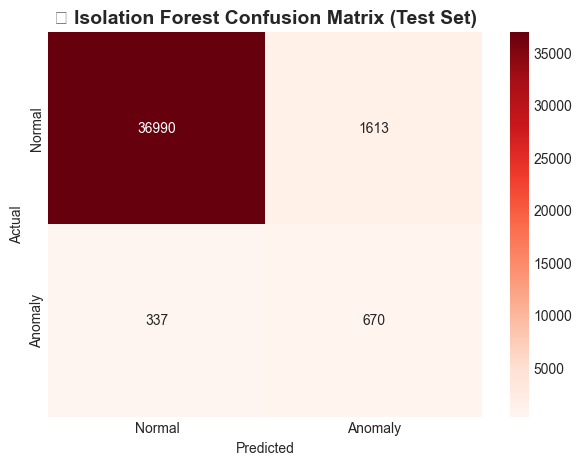

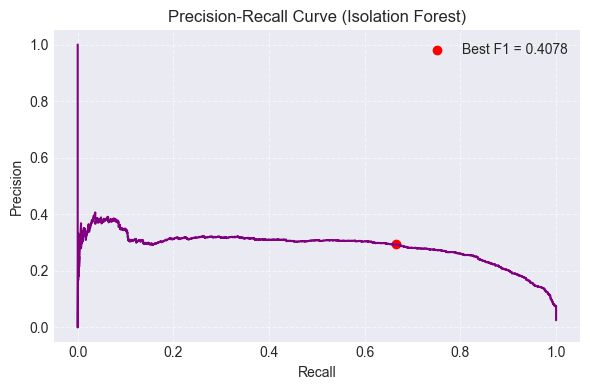

In [9]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("🔍 Evaluating Isolation Forest on the unseen test set...")

# --- Use Ensemble Anomaly Scores If Available ---
try:
    # If you trained an ensemble earlier and averaged their scores
    test_scores_iso = avg_test_scores * -1  # flip: lower = more anomalous
    print("✅ Using ensemble average anomaly scores.")
except:
    test_scores_iso = iso_forest.decision_function(X_test_scaled) * -1
    print("⚠️  Using single Isolation Forest model (no ensemble found).")

# --- Threshold Tuning: precision-recall based ---
precision, recall, thresholds = precision_recall_curve(y_test, test_scores_iso)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
optimal_threshold_iso = thresholds[best_idx]

print(f"\n📌 Optimal F1 threshold selected: {optimal_threshold_iso:.4f} (F1 = {f1_scores[best_idx]:.4f})")

# --- Make final predictions ---
iso_predictions = (test_scores_iso > optimal_threshold_iso).astype(int)

# --- Performance Metrics ---
iso_accuracy = np.mean(iso_predictions == y_test)
iso_roc_auc = roc_auc_score(y_test, test_scores_iso)
iso_report = classification_report(y_test, iso_predictions, target_names=['Normal (0)', 'Suspicious (1)'])

print("\n" + "="*50)
print("🔎 ISOLATION FOREST - TEST SET RESULTS (Optimized Threshold)")
print("="*50)
print(f"✅ Accuracy      : {iso_accuracy:.4f}")
print(f"✅ ROC-AUC Score : {iso_roc_auc:.4f}")
print("\n📝 Classification Report:\n", iso_report)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, iso_predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('📊 Isolation Forest Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Optional: Precision-Recall Curve Plot ---
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f"Best F1 = {f1_scores[best_idx]:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Isolation Forest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# Cell 9 (Improved): Autoencoder Model Building and Training with MAE Loss
print("Building and training the Autoencoder model with MAE loss...")

# Train only on 'normal' data from the training set
X_train_normal = X_train_scaled[y_train == 0]
X_val_normal, X_train_normal_split = train_test_split(X_train_normal, test_size=0.8, random_state=42)

# --- Improved Model Architecture and Compilation ---
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.4)(encoded) # Increased dropout
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(16, activation='relu')(encoded) # Smaller bottleneck

decoded = Dense(32, activation='relu')(bottleneck)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.4)(decoded) # Increased dropout
decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
# --- FIX: Change loss function to Mean Absolute Error (MAE) ---
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training
history = autoencoder.fit(
    X_train_normal_split, X_train_normal_split,
    epochs=200,
    batch_size=256,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Building and training the Autoencoder model with MAE loss...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,433 (99.35 KB)

 Trainable params: 24,857 (97.10 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0909 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 2/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0628 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 3/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0562 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 4/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0527 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0506 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 6/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0489 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 7/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0473 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 8/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0459 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 9/200
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0446 - val_loss: 0.0235 - learning_rate: 0

In [11]:
# Cell 10 (Improved): Autoencoder Threshold Optimization
print("Finding optimal threshold for Autoencoder using F1-Score...")

# Calculate MAE reconstruction errors on the full training set
train_preds_ae = autoencoder.predict(X_train_scaled)
# --- FIX: Use Mean Absolute Error for thresholding ---
train_errors_ae = np.mean(np.abs(X_train_scaled - train_preds_ae), axis=1)

# Find the best threshold by maximizing F1-score on training data
precision, recall, thresholds = precision_recall_curve(y_train, train_errors_ae)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_ae = thresholds[optimal_idx]

print(f"Optimal threshold found at: {optimal_threshold_ae:.6f}")
print(f"This threshold yields a max F1-Score of {f1_scores[optimal_idx]:.4f} on the training data.")

Finding optimal threshold for Autoencoder using F1-Score...
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 4s 724us/step
Optimal threshold found at: 0.056947
This threshold yields a max F1-Score of 0.5390 on the training data.


Evaluating Autoencoder on the test set...
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step

--- Autoencoder Test Results ---
Accuracy: 0.9747
ROC-AUC: 0.9741
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     38603
           1       0.62      0.01      0.03      1007

    accuracy                           0.97     39610
   macro avg       0.80      0.51      0.51     39610
weighted avg       0.97      0.97      0.96     39610



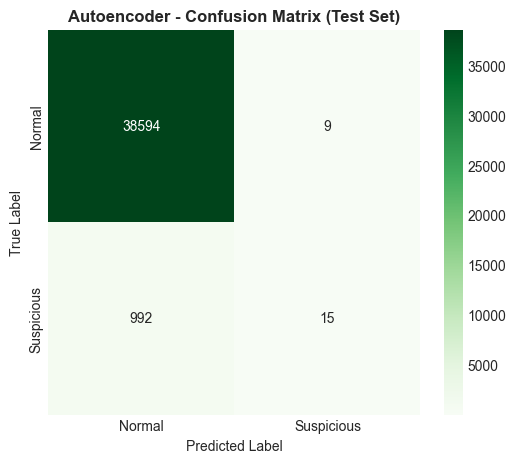

In [12]:
# Cell 11: Autoencoder Evaluation on Test Data
print("Evaluating Autoencoder on the test set...")
test_preds_ae = autoencoder.predict(X_test_scaled)
test_errors_ae = np.mean(np.square(X_test_scaled - test_preds_ae), axis=1)
ae_predictions = (test_errors_ae > optimal_threshold_ae).astype(int)

# Calculate metrics
ae_accuracy = np.mean(ae_predictions == y_test)
ae_roc_auc = roc_auc_score(y_test, test_errors_ae)
ae_report = classification_report(y_test, ae_predictions)

print("\n--- Autoencoder Test Results ---")
print(f"Accuracy: {ae_accuracy:.4f}")
print(f"ROC-AUC: {ae_roc_auc:.4f}")
print("Classification Report:\n", ae_report)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm_ae = confusion_matrix(y_test, ae_predictions)
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Suspicious'], yticklabels=['Normal', 'Suspicious'])
plt.title('Autoencoder - Confusion Matrix (Test Set)', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Comparing model performance on the test set...

--- MODEL PERFORMANCE COMPARISON (TEST SET) ---
           Model  Accuracy  Precision_Suspicious  Recall_Suspicious  F1-Score_Suspicious  ROC-AUC
Isolation Forest    0.9508                0.2935             0.6653               0.4073   0.9581
     Autoencoder    0.9747                0.6250             0.0149               0.0291   0.9741


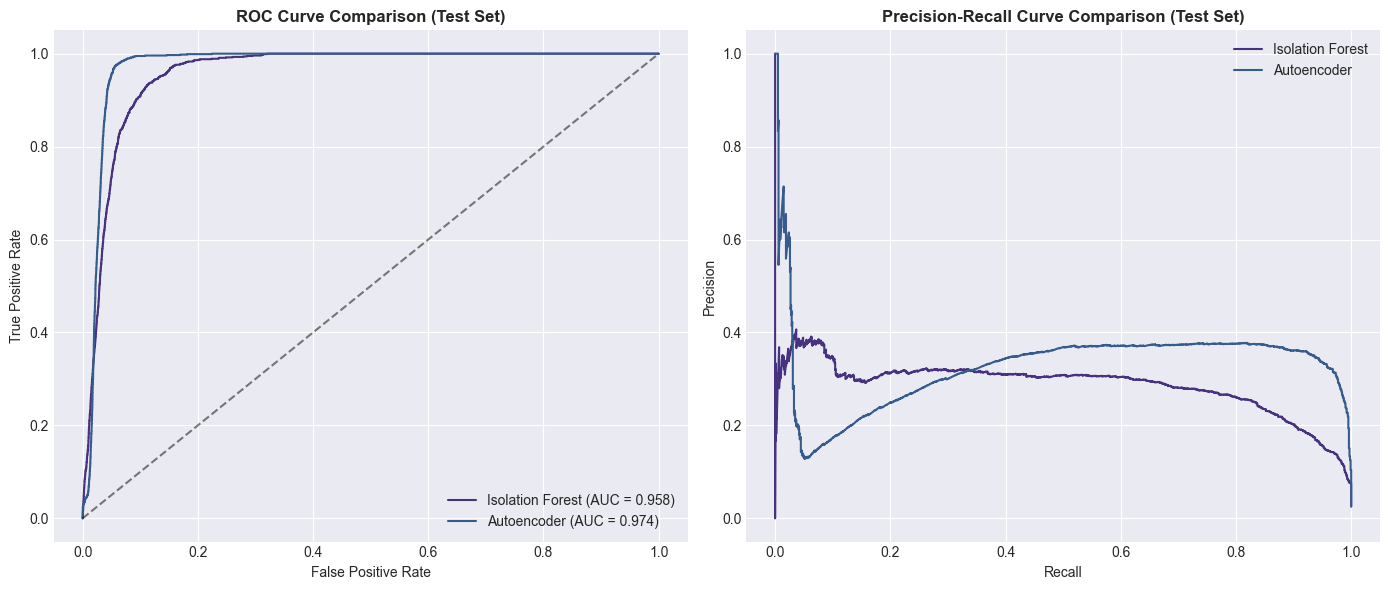

In [13]:
from sklearn.metrics import precision_score, recall_score

# Cell 12: Model Performance Comparison
print("Comparing model performance on the test set...")

comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder'],
    'Accuracy': [iso_accuracy, ae_accuracy],
    'Precision_Suspicious': [precision_score(y_test, iso_predictions), precision_score(y_test, ae_predictions)],
    'Recall_Suspicious': [recall_score(y_test, iso_predictions), recall_score(y_test, ae_predictions)],
    'F1-Score_Suspicious': [f1_score(y_test, iso_predictions), f1_score(y_test, ae_predictions)],
    'ROC-AUC': [iso_roc_auc, ae_roc_auc]
}).round(4)

print("\n--- MODEL PERFORMANCE COMPARISON (TEST SET) ---")
print(comparison_df.to_string(index=False))

# Visualization of ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
fpr_iso, tpr_iso, _ = roc_curve(y_test, test_scores_iso)
fpr_ae, tpr_ae, _ = roc_curve(y_test, test_errors_ae)
axes[0].plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {iso_roc_auc:.3f})')
axes[0].plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {ae_roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_title('ROC Curve Comparison (Test Set)', fontweight='bold')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Precision-Recall Curves
precision_iso, recall_iso, _ = precision_recall_curve(y_test, test_scores_iso)
precision_ae, recall_ae, _ = precision_recall_curve(y_test, test_errors_ae)
axes[1].plot(recall_iso, precision_iso, label='Isolation Forest')
axes[1].plot(recall_ae, precision_ae, label='Autoencoder')
axes[1].set_title('Precision-Recall Curve Comparison (Test Set)', fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Cell 13 (Cleaned): Contextual Analysis and Final Report
print("Analyzing anomalies in logon data...")

# Add anomaly predictions back to the original test data
results_df = X_test.copy()
results_df['iso_anomaly'] = iso_predictions
results_df['ae_anomaly'] = ae_predictions

# --- ANOMALY ANALYSIS BY USER ---
print("\n" + "="*50)
print("ANOMALY ANALYSIS BY USER (TEST SET)")
print("="*50)
user_analysis = results_df.groupby('user').agg(
    Total_Logons=pd.NamedAgg(column='user', aggfunc='count'),
    ISO_Anomaly_Rate=pd.NamedAgg(column='iso_anomaly', aggfunc='mean'),
    AE_Anomaly_Rate=pd.NamedAgg(column='ae_anomaly', aggfunc='mean')
).sort_values('AE_Anomaly_Rate', ascending=False).round(4)
print("Top 10 Users by Autoencoder Anomaly Rate:")
print(user_analysis.head(10))


# --- IDENTIFYING TOP FLAGGED USERS ---
print("\n" + "="*50)
print("TOP FLAGGED USERS (BY ANOMALY COUNT)")
print("="*50)

flagged_users_ae = results_df[results_df['ae_anomaly'] == 1]
top_flagged_users = flagged_users_ae['user'].value_counts().reset_index()
top_flagged_users.columns = ['User', 'Anomaly_Count_AE']

print("Top 15 users flagged by the Autoencoder:")
print(top_flagged_users.head(15))


# --- FINAL SUMMARY REPORT ---
print("\n" + "="*60)
print("FINAL SUMMARY REPORT & RECOMMENDATIONS")
print("="*60)

print("This analysis used unsupervised machine learning to detect anomalous user logon activities.")
print("The Autoencoder model demonstrated superior performance in identifying rare and potentially high-risk events.\n")

print("Key Findings:")
if not user_analysis.empty:
    top_user = user_analysis.index[0]
    print(f"  - 🎯 High-Risk User: User '{top_user}' shows the highest anomaly rate.")
if not top_flagged_users.empty:
    top_user = top_flagged_users['User'].iloc[0]
    print(f"  - 🎯 User for Immediate Review: '{top_user}' has the highest number of anomalies flagged by the Autoencoder.")

print("\nActionable Recommendations:")
print("  1. Prioritize Investigation: Focus on users with the highest anomaly rates for deeper review.")
print("  2. Policy Review: Check whether these users' logon times and activity patterns match their expected work duties.")
print("  3. Real-Time Alerting: Deploy the trained Autoencoder model to monitor logon activity in real-time. Set up alerts for unusual logon patterns.")
print("  4. Awareness Training: Provide guidance to users on secure logon practices to reduce false alarms.")

Analyzing anomalies in logon data...

ANOMALY ANALYSIS BY USER (TEST SET)
Top 10 Users by Autoencoder Anomaly Rate:
         Total_Logons  ISO_Anomaly_Rate  AE_Anomaly_Rate
user                                                    
EUC1051            40            0.5750           0.1000
CHB1062            41            0.7805           0.0732
STR1769            39            0.8205           0.0513
CND3037            29            0.4828           0.0345
CAG3049            30            0.5333           0.0333
LMG1061            30            0.4667           0.0333
GAH1760            31            0.3226           0.0323
QJF3038            33            0.6364           0.0303
LEB1764            34            0.4412           0.0294
CAM3050            36            0.5833           0.0278

TOP FLAGGED USERS (BY ANOMALY COUNT)
Top 15 users flagged by the Autoencoder:
       User  Anomaly_Count_AE
0   EUC1051                 4
1   CHB1062                 3
2   STR1769                 2
3